In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [4]:
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [5]:
project_data = project_data.head(50000)

## Clean Data

#### Subject categories

In [6]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [7]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

#### Subject sub categories

In [8]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [9]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

#### Preprocess Essay

In [10]:
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]


# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:38<00:00, 1296.15it/s]


In [12]:
project_data.drop(['essay'], axis=1, inplace=True)

In [13]:
project_data['essay'] = preprocessed_essays

#### Preprocess Title

In [14]:
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 32647.48it/s]


In [15]:
project_data.drop(['project_title'], axis=1, inplace=True)

In [16]:
project_data['project_title'] = preprocessed_title

##### Preprocess project_resource_summary

In [17]:
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_resource_summary'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_summary.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:03<00:00, 15532.88it/s]


In [18]:
project_data.drop(['project_resource_summary'], axis=1, inplace=True)

In [19]:
project_data['summary'] = preprocessed_summary

In [20]:
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_essay_1,project_essay_2,project_essay_3,project_essay_4,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,clean_categories,clean_subcategories,essay,project_title,summary
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,0,0,154.6,23,Literacy_Language,ESL Literacy,my students english learners working english s...,educational support english learners home,my students need opportunities practice beginn...


In [21]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_essay_1,project_essay_2,project_essay_3,project_essay_4,teacher_number_of_previously_posted_projects,price,quantity,clean_categories,clean_subcategories,essay,project_title,summary
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,0,154.6,23,Literacy_Language,ESL Literacy,my students english learners working english s...,educational support english learners home,my students need opportunities practice beginn...


In [22]:
y[0:10,]

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [23]:
X = project_data

# 1. Splitting Data

In [24]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

# 2. Creating Data Matrix

##  Bag of Words

### summary

In [138]:

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)



from sklearn.feature_extraction.text import CountVectorizer
bowvectorizer = CountVectorizer(min_df=10,ngram_range=(1,4))  #if needed max_features=5000 in brackets
bowvectorizer.fit(X_train['summary'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_summary_bow = bowvectorizer.transform(X_train['summary'].values)
X_cv_summary_bow = bowvectorizer.transform(X_cv['summary'].values)
X_test_summary_bow = bowvectorizer.transform(X_test['summary'].values)

print("After vectorizations")
print(X_train_summary_bow.shape, y_train.shape)
print(X_cv_summary_bow.shape, y_cv.shape)
print(X_test_summary_bow.shape, y_test.shape)
print("="*100)


print("NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME")


(22445, 19) (22445,)
(11055, 19) (11055,)
(16500, 19) (16500,)
After vectorizations
(22445, 6675) (22445,)
(11055, 6675) (11055,)
(16500, 6675) (16500,)
NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME


### project_title

In [139]:
from sklearn.feature_extraction.text import CountVectorizer
bowvectorizer = CountVectorizer(min_df=10,ngram_range=(1,4))  #if needed max_features=5000 in brackets
bowvectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_title_bow = bowvectorizer.transform(X_train['project_title'].values)
X_cv_project_title_bow = bowvectorizer.transform(X_cv['project_title'].values)
X_test_project_title_bow = bowvectorizer.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_project_title_bow.shape, y_train.shape)
print(X_cv_project_title_bow.shape, y_cv.shape)
print(X_test_project_title_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1978) (22445,)
(11055, 1978) (11055,)
(16500, 1978) (16500,)


## TF IDF 

### Summary

In [140]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfvectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4))  #if needed max_features=5000 in brackets
tfvectorizer.fit(X_train['summary'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_summary_tfidf = tfvectorizer.transform(X_train['summary'].values)
X_cv_summary_tfidf = tfvectorizer.transform(X_cv['summary'].values)
X_test_summary_tfidf = tfvectorizer.transform(X_test['summary'].values)

print("After vectorizations")
print(X_train_summary_tfidf.shape, y_train.shape)
print(X_cv_summary_tfidf.shape, y_cv.shape)
print(X_test_summary_tfidf.shape, y_test.shape)

After vectorizations
(22445, 6675) (22445,)
(11055, 6675) (11055,)
(16500, 6675) (16500,)


### Title

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfvectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4))  #if needed max_features=5000 in brackets
tfvectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_title_tfidf = tfvectorizer.transform(X_train['project_title'].values)
X_cv_project_title_tfidf = tfvectorizer.transform(X_cv['project_title'].values)
X_test_project_title_tfidf = tfvectorizer.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_project_title_tfidf.shape, y_train.shape)
print(X_cv_project_title_tfidf.shape, y_cv.shape)
print(X_test_project_title_tfidf.shape, y_test.shape)

After vectorizations
(22445, 1978) (22445,)
(11055, 1978) (11055,)
(16500, 1978) (16500,)


## Categorical features

## school_state

In [29]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 51) (22445,)
(11055, 51) (11055,)
(16500, 51) (16500,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


## teacher_prefix

In [30]:
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document

vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values.astype('U')) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values.astype('U'))
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values.astype('U'))
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values.astype('U'))
print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 6) (22445,)
(11055, 6) (11055,)
(16500, 6) (16500,)
['dr', 'mr', 'mrs', 'ms', 'nan', 'teacher']


## clean_categories

In [31]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_cv_clean_categories_ohe.shape, y_cv.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 9) (22445,)
(11055, 9) (11055,)
(16500, 9) (16500,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


## clean_subcategories

In [32]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clean_subcategories_ohe.shape, y_train.shape)
print(X_cv_clean_subcategories_ohe.shape, y_cv.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 30) (22445,)
(11055, 30) (11055,)
(16500, 30) (16500,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


## project_grade_category

In [33]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 3) (22445,)
(11055, 3) (11055,)
(16500, 3) (16500,)
['12', 'grades', 'prek']


## Numerical Features

##  Price

In [34]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


##  teacher_number_of_previously_posted_projects

In [35]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_tnppp_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_tnppp_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_tnppp_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_tnppp_norm.shape, y_train.shape)
print(X_cv_tnppp_norm.shape, y_cv.shape)
print(X_test_tnppp_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)



## 2.5 Concatinating all the features

In [36]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_summary_bow,X_train_project_title_bow, X_train_state_ohe, X_train_teacher_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe, X_train_grade_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
X_cr = hstack((X_cv_summary_bow,X_cv_project_title_bow, X_cv_state_ohe, X_cv_teacher_ohe,X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe, X_cv_grade_ohe, X_cv_price_norm, X_cv_tnppp_norm)).tocsr()
X_te = hstack((X_test_summary_bow,X_test_project_title_bow, X_test_state_ohe, X_test_teacher_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe, X_test_grade_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 8754) (22445,)
(11055, 8754) (11055,)
(16500, 8754) (16500,)


# 1: Hyper parameter Tuning

## Bag of Words

In [37]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

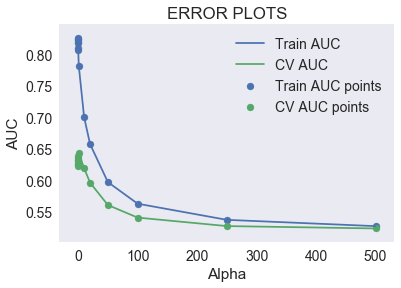

In [150]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
K = [0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1, 1, 10, 20, 50, 100, 250, 500]
for i in K:
    bmnb = MultinomialNB(alpha=i)
    bmnb.fit(X_tr, y_train)

    y_train_pred = batch_predict(bmnb, X_tr)    
    y_cv_pred = batch_predict(bmnb, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [151]:
#https://stackoverflow.com/questions/46661002/sklearn-gridsearchcv-over-n-iter-parameter

from sklearn.model_selection import GridSearchCV

bbmnb = MultinomialNB()
parameters = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
clf = GridSearchCV(bbmnb, parameters, cv=3, scoring='roc_auc')
clf.fit(X_tr, y_train)
print("Best HyperParameter: ",clf.best_params_)

Best HyperParameter:  {'alpha': 0.5}


In [73]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_i = 0.5

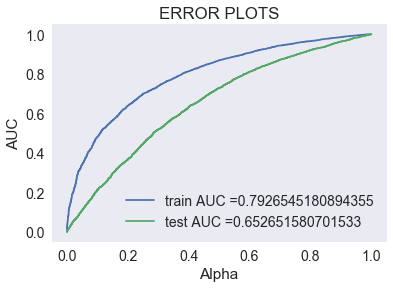

In [74]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

mnb = MultinomialNB(alpha=best_i)
mnb.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(mnb, X_tr)    
y_test_pred = batch_predict(mnb, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [42]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24999997915341 for threshold 0.238


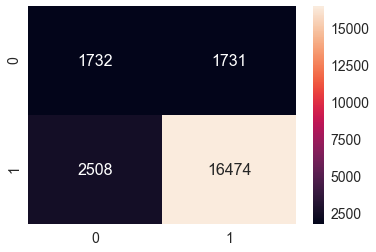

In [75]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix


print("Train confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.637


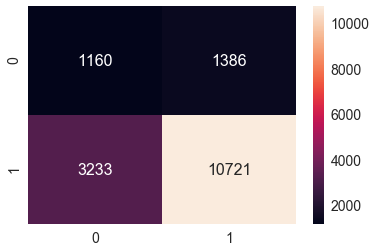

In [76]:
print("Test confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## TF-IDF

In [61]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
tX_tr = hstack((X_train_summary_tfidf,X_train_project_title_tfidf, X_train_state_ohe, X_train_teacher_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe, X_train_grade_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
tX_cr = hstack((X_cv_summary_tfidf,X_cv_project_title_tfidf, X_cv_state_ohe, X_cv_teacher_ohe,X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe, X_cv_grade_ohe, X_cv_price_norm, X_cv_tnppp_norm)).tocsr()
tX_te = hstack((X_test_summary_tfidf,X_test_project_title_tfidf, X_test_state_ohe, X_test_teacher_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe, X_test_grade_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(tX_tr.shape, y_train.shape)
print(tX_cr.shape, y_cv.shape)
print(tX_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 8754) (22445,)
(11055, 8754) (11055,)
(16500, 8754) (16500,)


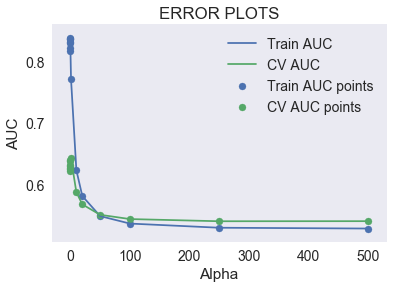

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


train_auc = []
cv_auc = []
K = [0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1, 1, 10, 20, 50, 100, 250, 500]
for i in K:
    tmnb = MultinomialNB(alpha=i)
    tmnb.fit(tX_tr, y_train)

    y_train_pred = batch_predict(tmnb, tX_tr)    
    y_cv_pred = batch_predict(tmnb, tX_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [70]:
#https://stackoverflow.com/questions/46661002/sklearn-gridsearchcv-over-n-iter-parameter

from sklearn.model_selection import GridSearchCV

ttmnb = MultinomialNB()
parameters = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
tclf = GridSearchCV(ttmnb, parameters, cv=3, scoring='roc_auc')
tclf.fit(tX_tr, y_train)
print("Best HyperParameter: ",tclf.best_params_)

Best HyperParameter:  {'alpha': 0.1}


In [64]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
tbest_i = 0.1

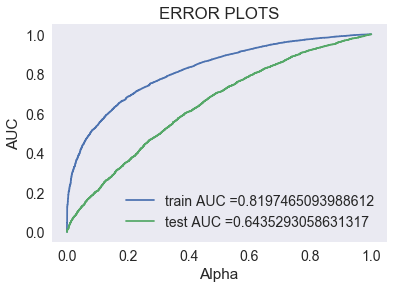

In [65]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

mnb = MultinomialNB(alpha=tbest_i)
mnb.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(mnb, tX_tr)    
y_test_pred = batch_predict(mnb, tX_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24999997915341 for threshold 0.679


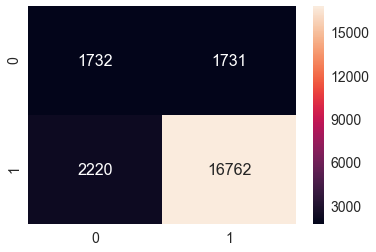

In [66]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix


print("Train confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.783


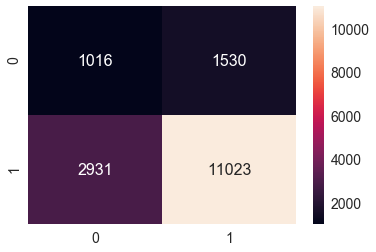

In [67]:
print("Test confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Selecting top 10 features

###### With BOW

In [158]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(bowvectorizer,bmnb)

			Positive						Negative
________________________________________________________________________________________________
	-9.2100	based learning 				-7.2592	kindergarten students
	-9.2060	baseball       				-7.3911	exploration    
	-9.2060	encourage      				-7.9810	just right     
	-9.2060	little learners				-8.0897	help us learn  
	-9.2040	21st century technology				-8.1301	interactive notebooks
	-9.2040	dramatic       				-8.2316	an apple day   
	-9.2040	fresh          				-8.2751	need chromebooks
	-9.2040	kits           				-8.3438	book club      
	-9.2040	know           				-8.3787	to             
	-9.2040	learning fun   				-8.3787	adding         


###### With TF-IDF

In [157]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfvectorizer,tmnb)

			Positive						Negative
________________________________________________________________________________________________
	-9.1348	based learning 				-8.5917	kindergarten students
	-9.1339	baseball       				-8.6221	exploration    
	-9.1336	encourage      				-8.8090	just right     
	-9.1333	little learners				-8.8370	interactive notebooks
	-9.1331	special        				-8.8613	help us learn  
	-9.1330	sitting        				-8.8892	an apple day   
	-9.1329	dramatic       				-8.9034	need chromebooks
	-9.1329	our target     				-8.9355	adding         
	-9.1328	learning fun   				-8.9375	to             
	-9.1328	21st century technology				-8.9377	balls          


We can see that both BOW and TF-IDF showed mostly similar results.

## Summary

In [77]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter","TrainAUC","TestAUC"]

x.add_row(["BOW", "Multinominal", 0.5, 0.79, 0.65])
x.add_row(["TFIDF", "Multinominal", 0.1, 0.81, 0.64])


print(x)

+------------+--------------+----------------+----------+---------+
| Vectorizer |    Model     | Hyperparameter | TrainAUC | TestAUC |
+------------+--------------+----------------+----------+---------+
|    BOW     | Multinominal |      0.5       |   0.79   |   0.65  |
|   TFIDF    | Multinominal |      0.1       |   0.81   |   0.64  |
+------------+--------------+----------------+----------+---------+


BOW does the best job.